In [1]:
from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as F
from pyspark.sql import types as T
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import seaborn as sns
from PIL import Image
import pandas as pd
import numpy as np
import os
import joblib
import cloudpickle

pd.set_option('display.max_columns', None)

from sklearnex import patch_sklearn
patch_sklearn()

from pyspark import SparkConf, SparkContext

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [109]:
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.metrics import r2_score, roc_auc_score, roc_curve
import seaborn as sn

In [2]:
conf = SparkConf()
conf.set("spark.executor.memory", "3g")
conf.set("spark.executor.cores", "1")
conf.set("spark.executor.instances", "12")

sc = SparkContext(conf=conf)
spark = SparkSession.builder.appName('AcidSoils').getOrCreate()

23/10/05 00:15:41 WARN Utils: Your hostname, Antons-iMac.local resolves to a loopback address: 127.0.0.1; using 192.168.2.200 instead (on interface en0)
23/10/05 00:15:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/05 00:15:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/05 00:15:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
disk_path = "/Volumes/hasuriski 1/LAYERS_15"

COLUMNS = [
    "elevation", 
    "aspect", 
    "aem_imag", 
    "aem_real", 
    "landsat_0", 
    "landsat_1", 
    "landsat_2", 
    "NDVI", 
    "TPI", 
    "TWI", 
    "TRI",
]

In [4]:
## Load points

In [5]:
source = gpd.read_file("../local_data/GTK_ASsoil_obs.csv")
geom = gpd.points_from_xy(source.POINT_X.astype("float"), source.POINT_Y.astype("float"))
points = gpd.GeoDataFrame(source.CLASS, crs="EPSG:3067", geometry=geom).to_crs("WGS84")
points["x"] = points.geometry.x
points["y"] = points.geometry.y
del points["geometry"]
points["point_id"] = points.index
points.head(4)

,CLASS,x,y,point_id
0,ASS,25.768938,64.777988,0
1,ASS,25.776304,64.793496,1
2,ASS,25.784691,64.786808,2
3,ASS,25.315115,64.988732,3


In [6]:
df_points = spark.createDataFrame(points).repartition(8*12)
df_points.show(4, truncate=False)

/Users/akusok/Library/Caches/pypoetry/virtualenvs/hasuriski-maps-YSf_3nsv-py3.11/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


+-----+------------------+-----------------+--------+
|CLASS|x                 |y                |point_id|
+-----+------------------+-----------------+--------+
|ASS  |23.651719700690382|63.83146044805958|661     |
|ASS  |26.059214999143336|64.56674817060245|365     |
|ASS  |23.166390179617235|63.83787019790163|628     |
|ASS  |25.863383983707035|65.42171983785249|144     |
+-----+------------------+-----------------+--------+
only showing top 4 rows



In [7]:
df_points.groupby('CLASS').count().show()

+-------+-----+
|  CLASS|count|
+-------+-----+
|    ASS| 3490|
|non-ASS| 2334|
+-------+-----+



## Get tile coordinates

In [8]:
# use Papermill to run this

ZOOM = 15
TILE_SIZE = 256

In [9]:
@F.udf(returnType=T.ArrayType(T.IntegerType()))
def project_pixel(lon, lat, zoom=ZOOM):
    # lon, lat = p.geometry.x, p.geometry.y
    
    siny = np.sin(lat * np.pi / 180)
    siny = min(max(siny, -0.9999), 0.9999)
    
    x = TILE_SIZE * (0.5 + lon / 360)
    y = TILE_SIZE * (0.5 - np.log((1 + siny) / (1 - siny)) / (4 * np.pi))
    
    scale = 2**zoom

    tx = x * scale // TILE_SIZE
    ty = y * scale // TILE_SIZE

    px = x * scale % TILE_SIZE // 1
    py = y * scale % TILE_SIZE // 1

    return [int(px), int(py)]
    
    
@F.udf(returnType=T.ArrayType(T.IntegerType()))
def project_tile(lon, lat, zoom=ZOOM):
    # lon, lat = p.geometry.x, p.geometry.y
    
    siny = np.sin(lat * np.pi / 180)
    siny = min(max(siny, -0.9999), 0.9999)
    
    x = TILE_SIZE * (0.5 + lon / 360)
    y = TILE_SIZE * (0.5 - np.log((1 + siny) / (1 - siny)) / (4 * np.pi))
    
    scale = 2**zoom

    tx = x * scale // TILE_SIZE
    ty = y * scale // TILE_SIZE

    px = x * scale % TILE_SIZE // 1
    py = y * scale % TILE_SIZE // 1

    return [int(zoom), int(tx), int(ty)]

In [10]:
df_tiles = (
    df_points
    .withColumn("pixel", project_pixel(df_points.x, df_points.y))
    .withColumn("tile", project_tile(df_points.x, df_points.y))
    .withColumn("pixel_coord", F.array(F.col("pixel")[0], F.col("pixel")[1], F.col("point_id")))
    .withColumn("class", (F.col("CLASS") == "ASS").astype("int"))
)

In [11]:
df_tiles.show(4)

+-----+------------------+-----------------+--------+----------+-----------------+---------------+
|class|                 x|                y|point_id|     pixel|             tile|    pixel_coord|
+-----+------------------+-----------------+--------+----------+-----------------+---------------+
|    1|23.651719700690382|63.83146044805958|     661|[213, 230]|[15, 18536, 8773]|[213, 230, 661]|
|    1|26.059214999143336|64.56674817060245|     365| [247, 30]|[15, 18755, 8620]| [247, 30, 365]|
|    1|23.166390179617235|63.83787019790163|     628|[168, 147]|[15, 18492, 8772]|[168, 147, 628]|
|    1|25.863383983707035|65.42171983785249|     144|   [36, 0]|[15, 18738, 8436]|   [36, 0, 144]|
+-----+------------------+-----------------+--------+----------+-----------------+---------------+
only showing top 4 rows



## Re-load processed data

In [12]:
df_tile_coords = (
    df_tiles
    .groupby("tile")
    .agg(F.collect_list("pixel_coord").alias("pixel_coord_list"))
)

In [98]:
@F.udf(returnType=T.ArrayType(T.ArrayType(T.FloatType())))
def load_combined_data(tile, pixel_coord, tiles):
    """
    tiles: folder with tiles
    """
    (z, tx, ty) = tile
    fname = tiles.format(z=z, x=tx, y=ty)
    
    try:
        arr_img = np.load(fname)
    except FileNotFoundError:
        # print(tiles, [pid for _,_,pid in pixel_coord])
        # return [(-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, pid) for _,_,pid in pixel_coord]
        return None

    data = []
    for i, j, pid in pixel_coord:
        pixel = arr_img[i*256 + j]
        data.append([
            *(float(p) for p in pixel), 
            float(pid),
        ])
        
    return data

In [99]:
def get_layer_data(tiles_path, prefix):
    npy_path = tiles_path + "/{z}/{x}/{y}.npy"
    df_data = (
        df_tile_coords
        .withColumn(
            "loaded_data", 
            load_combined_data(F.col("tile"), F.col("pixel_coord_list"), F.lit(npy_path))
        )
        .select(F.explode("loaded_data").alias("data"))
    )
    return df_data.select(
        F.col("data")[11].astype("int").alias("point_id"),
        *[F.col("data")[j].alias(f"{prefix}_{j}") for j in range(11)],
    )

In [100]:
dP = (
    df_tiles
    .select(
        "point_id",
        "class"
    )
    .join(
        get_layer_data(f"{disk_path}/combined_data", "x"),
        on="point_id",
        how="right"
    )
    .toPandas()
)

dP.head(3)

,point_id,class,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10
0,3129,0,1.325,0.214286,1.5875,1.500000,0.293333,1.015385,-0.56,-0.5,1.00,-0.400000,0.437982
1,614,1,1.200,-0.128571,-0.1000,0.733333,-1.800000,-1.553846,-0.98,-0.1,0.30,-0.857143,-0.473626
2,613,1,1.100,1.742857,1.6000,1.466667,-0.546667,-0.246154,-1.04,-0.3,0.25,0.314286,0.407021


In [105]:
Y = np.array(dP["class"]).astype("float32")
X = np.array(dP.iloc[:, 2:])

X.shape, Y.shape, Y.mean()

((5686, 11), (5686,), 0.60429126)

In [102]:
Y

array([0., 1., 1., ..., 0., 1., 0.], dtype=float32)

In [103]:
X

array([[ 1.325     ,  0.21428572,  1.5875    , ...,  1.        ,
        -0.4       ,  0.43798208],
       [ 1.2       , -0.12857144, -0.1       , ...,  0.3       ,
        -0.85714287, -0.47362566],
       [ 1.1       ,  1.7428571 ,  1.6       , ...,  0.25      ,
         0.31428573,  0.40702105],
       ...,
       [-1.2       , -1.5142857 , -1.4       , ...,  0.75      ,
         0.6571429 ,  0.58996916],
       [-1.425     ,  0.27142859, -1.525     , ...,  0.3       ,
         0.25714287, -0.32763004],
       [-1.35      ,  1.2142857 , -0.4125    , ..., -0.05      ,
         0.02857143, -0.43672562]], dtype=float32)

## Re-train ELM

In [106]:
L = 150 

W = np.random.randn(11, L) / 11**0.5
bias = np.random.randn(L)

np.save(f"../local_data/W_{L}.npy", W.astype("float32"))
np.save(f"../local_data/bias_{L}.npy", bias.astype("float32"))

In [168]:
H = np.tanh(X@W + bias)
B = np.linalg.solve(H.T@H + np.eye(L)*1e+2, H.T@Y)
Yh = H@B

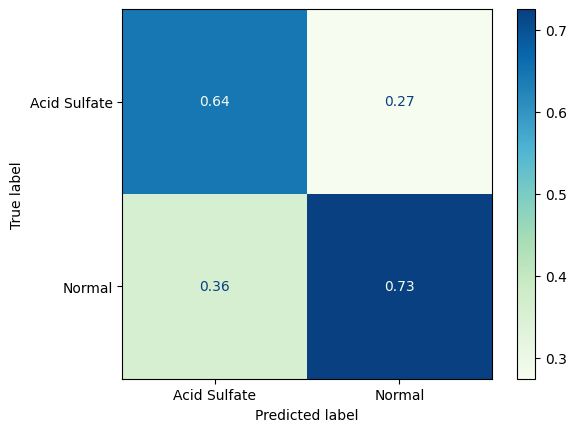

In [169]:
ConfusionMatrixDisplay(
    confusion_matrix(Y, (Yh > 0.5), normalize="pred"),
    display_labels=["Acid Sulfate", "Normal"],
).plot(cmap="GnBu")

## Re-run ELM and plot

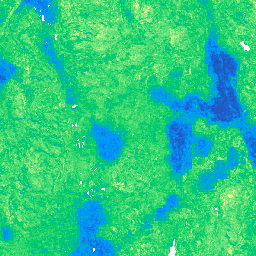

In [170]:
fname = "/Volumes/hasuriski 1/LAYERS_15/combined_data/12/2299/1113.npy"

Image.open(fname.replace(".npy", ".png").replace("combined_data", "predict_terrain"))

In [171]:
X1 = np.load(fname)
H1 = np.tanh(X1@W + bias)
Y1 = H1@B

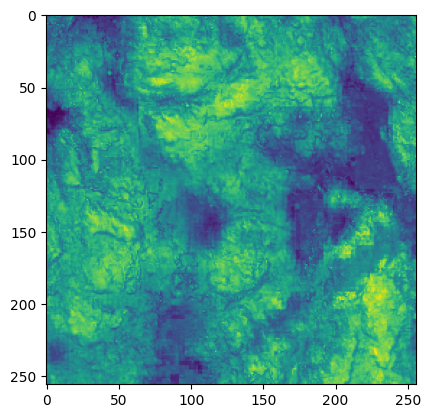

In [172]:
plt.imshow(1 - Y1.reshape(256, 256))